In [1]:
import os
import numpy as np
import pandas as pd

def load_eeg_data(data_dir):
    rows = []

    for condition in ['Healthy', 'AD']:
        for state in ['Eyes_open', 'Eyes_closed']:
            folder_path = os.path.join(data_dir, condition, state)
            if not os.path.exists(folder_path):
                print(f"Directory {folder_path} not found.")
                continue

            for paciente in os.listdir(folder_path):
                paciente_folder = os.path.join(folder_path, paciente)
                if os.path.isdir(paciente_folder):
                    for file in os.listdir(paciente_folder):
                        if file.endswith('.txt'):
                            file_path = os.path.join(paciente_folder, file)
                            try:
                                data = np.loadtxt(file_path)
                                rows.append({
                                    'Condition': condition,
                                    'State': state,
                                    'Patient': paciente,
                                    'File': file,
                                    'Signal': data
                                })
                            except Exception as e:
                                print(f"Error loading {file_path}: {e}")
    
    eeg_df = pd.DataFrame(rows)
    print("EEG data loaded successfully. Number of records:", len(eeg_df))
    return eeg_df

# Étape 1 : Charger les données EEG
data_dir = "./EEG_data"
eeg_data_df = load_eeg_data(data_dir)

# Étape 2 : Nettoyage des données
def clean_data(df):
    # Supprimer les lignes avec des valeurs manquantes dans le signal
    df = df.dropna(subset=['Signal'])
    print("Valeurs manquantes supprimées. Nombre de lignes restantes :", len(df))

    # Filtrer les valeurs aberrantes : par exemple, en supprimant les signaux avec des amplitudes extrêmes
    df = df[df['Signal'].apply(lambda x: np.all(np.abs(x) < 1000))]  # Exemple de seuil
    print("Valeurs aberrantes filtrées. Nombre de lignes restantes :", len(df))

    # Normaliser les données si nécessaire
    df['Signal'] = df['Signal'].apply(lambda x: (x - np.mean(x)) / np.std(x))
    print("Les signaux ont été normalisés.")

    return df

# Appliquer le nettoyage des données
eeg_data_cleaned = clean_data(eeg_data_df)


EEG data loaded successfully. Number of records: 3841
Valeurs manquantes supprimées. Nombre de lignes restantes : 3841
Valeurs aberrantes filtrées. Nombre de lignes restantes : 3841
Les signaux ont été normalisés.


In [2]:
# Afficher les données pour les premiers patients
print(eeg_data_df.head())


  Condition      State    Patient    File  \
0   Healthy  Eyes_open  Paciente1  C3.txt   
1   Healthy  Eyes_open  Paciente1  C4.txt   
2   Healthy  Eyes_open  Paciente1  Cz.txt   
3   Healthy  Eyes_open  Paciente1  F1.txt   
4   Healthy  Eyes_open  Paciente1  F2.txt   

                                              Signal  
0  [-0.9901, 3.9604, 11.881, 15.842, 12.871, 10.8...  
1  [1.9529, -0.06734, -1.0774, -1.0774, 1.9529, 4...  
2  [5.8667, 6.8667, 5.8667, 3.8667, 2.8667, 4.866...  
3  [5.9406, 1.9802, -0.9901, -1.9802, -1.9802, 0....  
4  [3.8188, 3.8188, 5.7605, -2.9773, -5.89, 7.702...  


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Charger les données brutes EEG (supposons que eeg_data_cleaned soit votre DataFrame contenant les signaux bruts)
# Nous allons utiliser la colonne 'Signal' comme données d'entrée

# Préparation des données
def prepare_raw_data(df):
    # Les signaux EEG bruts sont des séries de valeurs. Pour simplifier, nous allons les aplatir.
    X = np.vstack(df['Signal'].values)  # Transformer la colonne 'Signal' en matrice d'entrée
    y = df['Condition'].apply(lambda x: 1 if x == 'AD' else 0)  # 1 pour AD, 0 pour Healthy
    return X, y

# Appliquer la préparation
X, y = prepare_raw_data(eeg_data_cleaned)

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Créer et entraîner le modèle d'arbre de décision
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
print("Modèle d'arbre de décision entraîné avec succès.")

# Prédire les résultats sur l'ensemble de test
y_pred = model.predict(X_test)

# Afficher le rapport de classification et la précision
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Affichage de l'arbre de décision
from sklearn.tree import export_text
tree_text = export_text(model)
print("Arbre de décision :\n", tree_text)


Modèle d'arbre de décision entraîné avec succès.
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.69      0.72       166
           1       0.95      0.96      0.96       987

    accuracy                           0.92      1153
   macro avg       0.85      0.83      0.84      1153
weighted avg       0.92      0.92      0.92      1153

Accuracy: 0.9236773633998265
Arbre de décision :
 |--- feature_99 <= 1.25
|   |--- feature_19 <= -1.92
|   |   |--- feature_4 <= -1.03
|   |   |   |--- feature_196 <= -0.46
|   |   |   |   |--- class: 1
|   |   |   |--- feature_196 >  -0.46
|   |   |   |   |--- feature_493 <= -1.67
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_493 >  -1.67
|   |   |   |   |   |--- class: 0
|   |   |--- feature_4 >  -1.03
|   |   |   |--- feature_820 <= 0.69
|   |   |   |   |--- class: 1
|   |   |   |--- feature_820 >  0.69
|   |   |   |   |--- class: 0
|   |--- feature_19 >  -1.92
|   |   |---

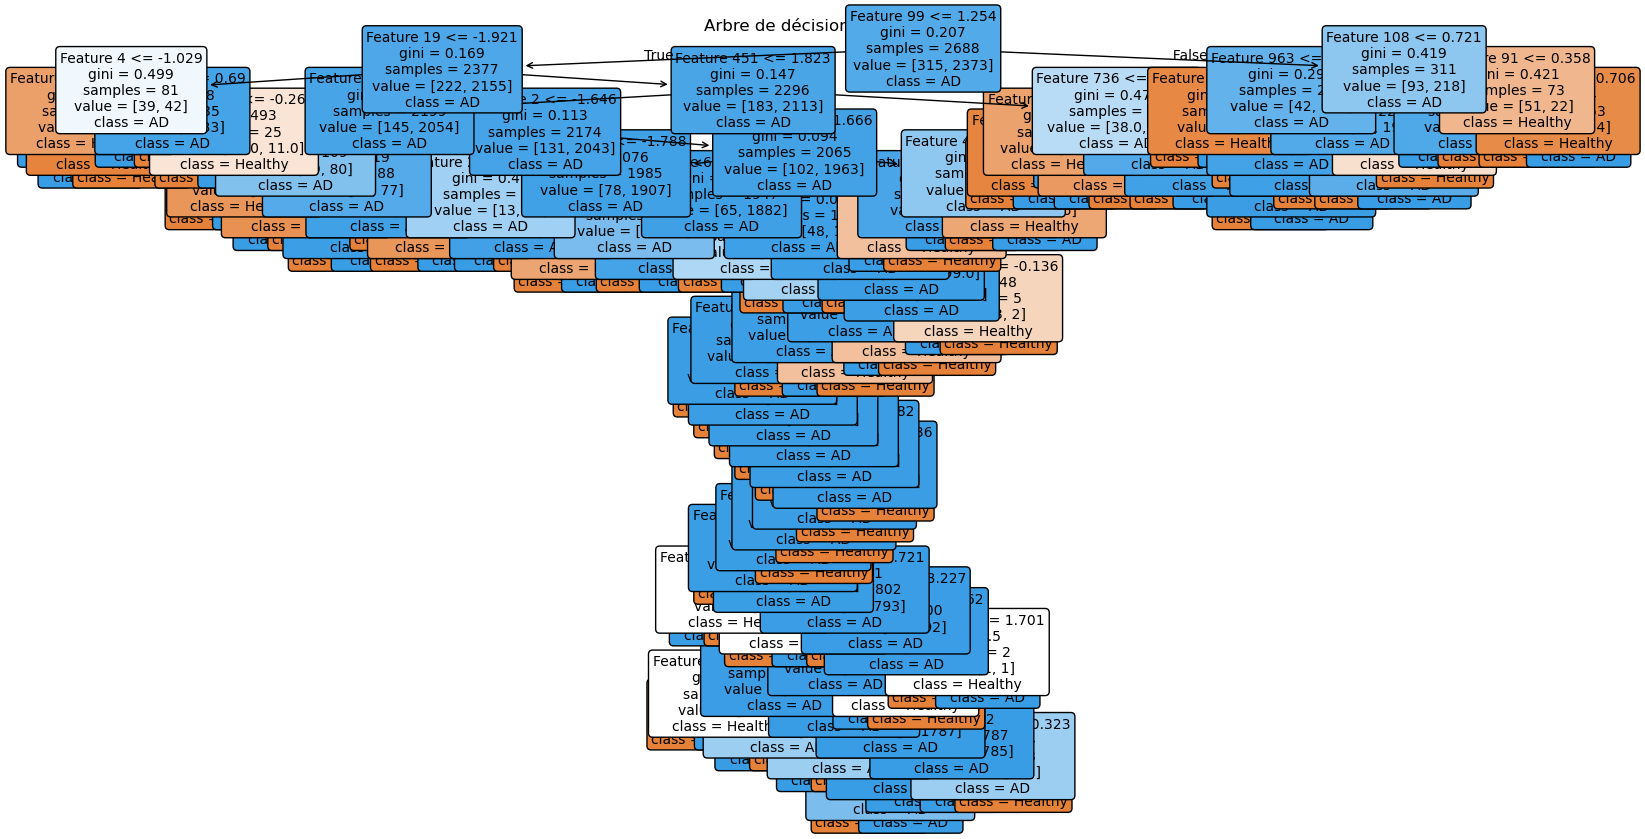

In [4]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Afficher l'arbre de décision
plt.figure(figsize=(20, 10))  # Ajuster la taille de l'image
plot_tree(
    model,
    feature_names=[f'Feature {i}' for i in range(X.shape[1])],  # Utilisation de noms génériques pour les caractéristiques
    class_names=['Healthy', 'AD'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Arbre de décision - EEG Data")
plt.show()


Rapport de classification - Arbre de Décision :
               precision    recall  f1-score   support

           0       0.76      0.69      0.72       166
           1       0.95      0.96      0.96       987

    accuracy                           0.92      1153
   macro avg       0.85      0.83      0.84      1153
weighted avg       0.92      0.92      0.92      1153

Accuracy du modèle : 0.92


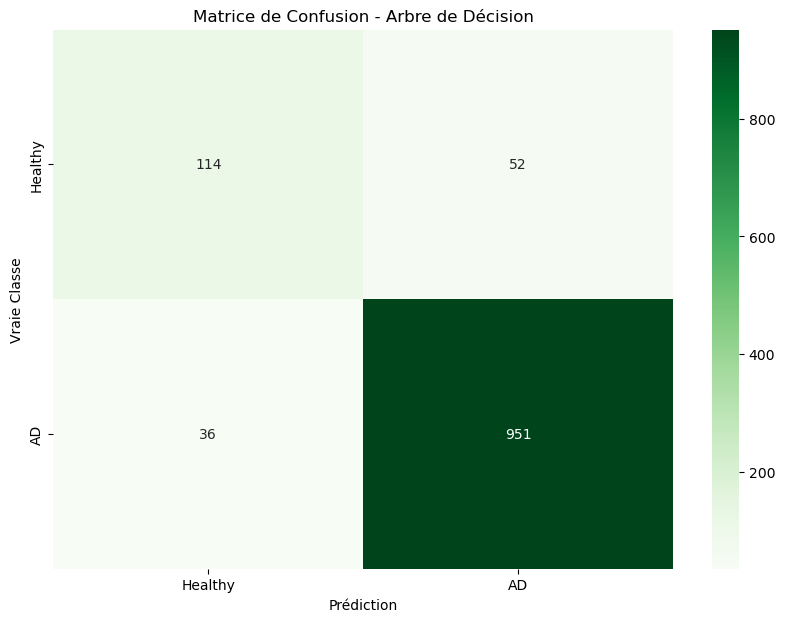

In [5]:
from sklearn.metrics import accuracy_score

# Afficher le rapport de classification
print("Rapport de classification - Arbre de Décision :\n", classification_report(y_test, y_pred))

# Calculer l'accuracy sur les données de test
accuracy = accuracy_score(y_test, y_pred)

# Afficher l'accuracy
print(f"Accuracy du modèle : {accuracy:.2f}")


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
cm_decision_tree = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(cm_decision_tree, annot=True, fmt="d", cmap="Greens", xticklabels=['Healthy', 'AD'], yticklabels=['Healthy', 'AD'])
plt.xlabel("Prédiction")
plt.ylabel("Vraie Classe")
plt.title("Matrice de Confusion - Arbre de Décision")
plt.show()



Modèle de forêt aléatoire entraîné avec succès.


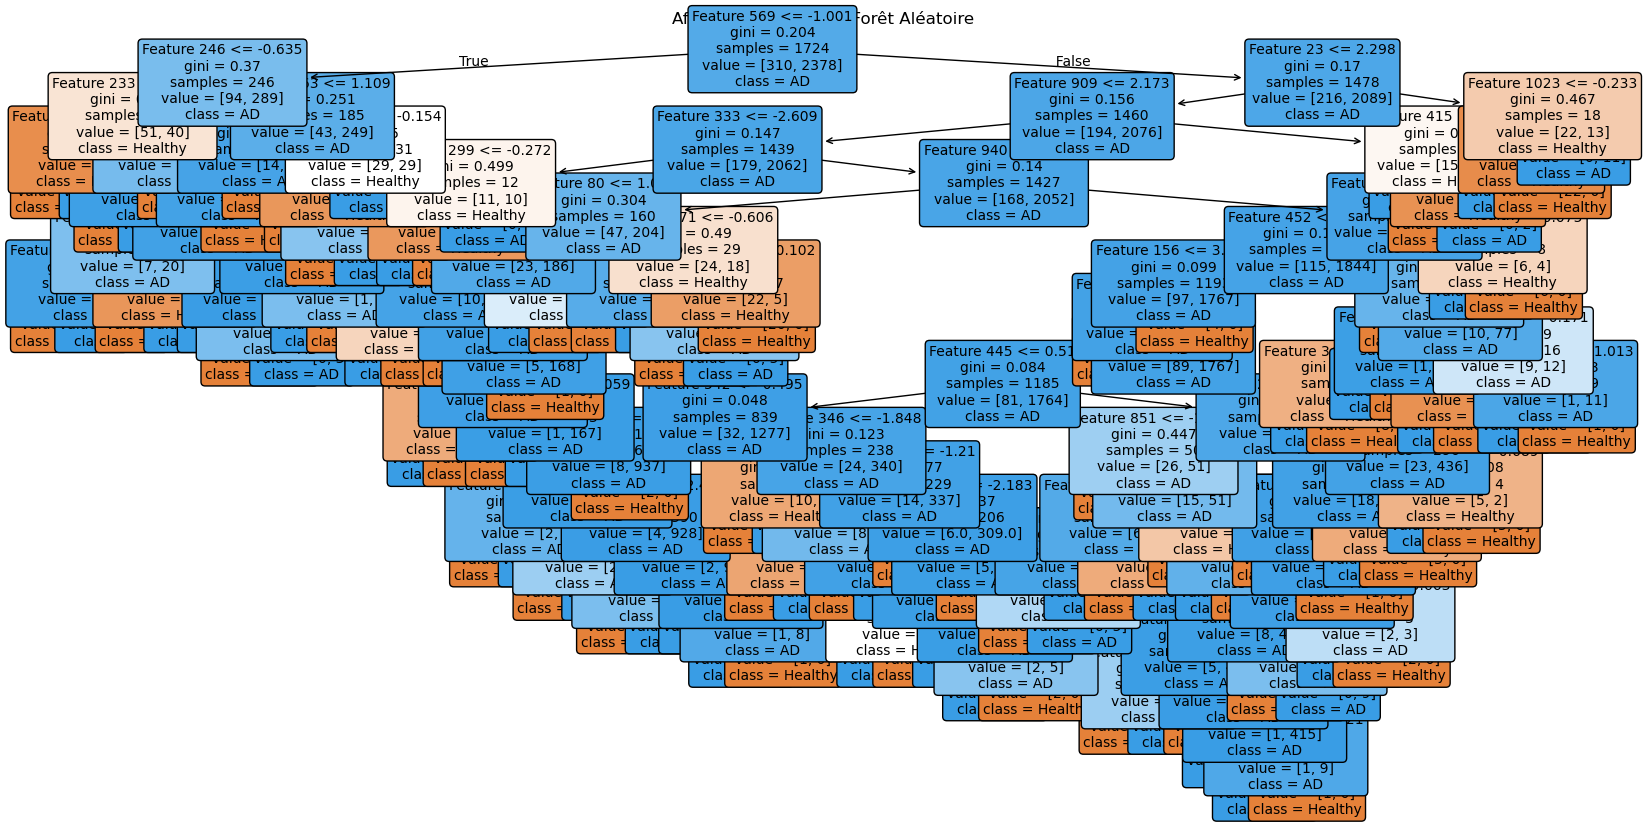

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Créer et entraîner le modèle de forêt aléatoire
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)
print("Modèle de forêt aléatoire entraîné avec succès.")

# Prédire les résultats sur l'ensemble de test
y_pred_rf = random_forest_model.predict(X_test)

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Sélectionner un arbre de la forêt aléatoire (par exemple, le premier arbre)
plt.figure(figsize=(20, 10))  # Ajuster la taille de l'image
plot_tree(
    random_forest_model.estimators_[0],  # Premier arbre de la forêt
    feature_names=[f'Feature {i}' for i in range(X.shape[1])],  # Utiliser les noms de caractéristiques génériques
    class_names=['Healthy', 'AD'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Affichage de l'arbre - Forêt Aléatoire")
plt.show()


Rapport de classification - Forêt Aléatoire :
               precision    recall  f1-score   support

           0       1.00      0.66      0.79       166
           1       0.95      1.00      0.97       987

    accuracy                           0.95      1153
   macro avg       0.97      0.83      0.88      1153
weighted avg       0.95      0.95      0.95      1153

Accuracy (précision) de la Forêt Aléatoire : 0.9505637467476149


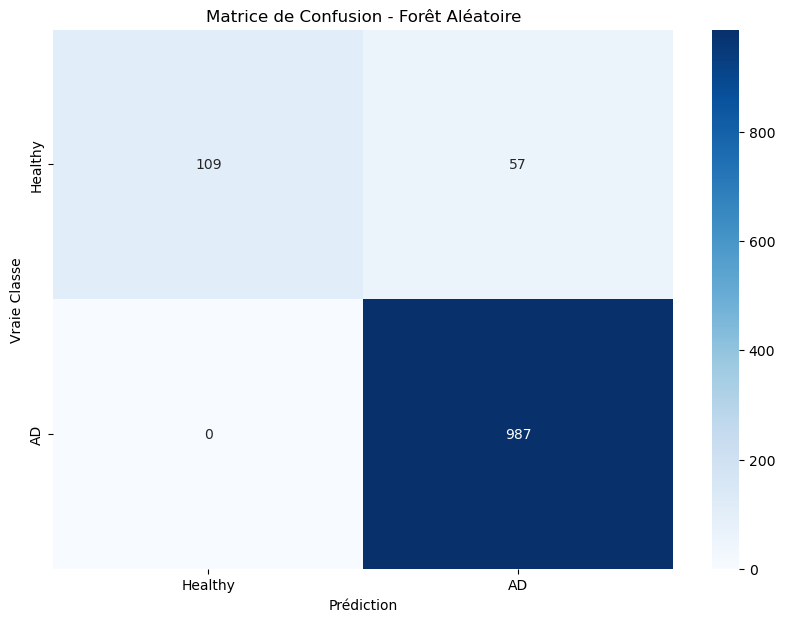

In [7]:
from sklearn.metrics import classification_report, accuracy_score

# Afficher le rapport de classification
print("Rapport de classification - Forêt Aléatoire :\n", classification_report(y_test, y_pred_rf))
print("Accuracy (précision) de la Forêt Aléatoire :", accuracy_score(y_test, y_pred_rf))

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_rf)

# Afficher la matrice de confusion sous forme graphique
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'AD'], yticklabels=['Healthy', 'AD'])
plt.xlabel("Prédiction")
plt.ylabel("Vraie Classe")
plt.title("Matrice de Confusion - Forêt Aléatoire")
plt.show()



Modèle KNN entraîné avec succès.
Prédictions KNN sur les premières données de test :
Prédiction : 1, Véritable étiquette : 1
Prédiction : 1, Véritable étiquette : 1
Prédiction : 1, Véritable étiquette : 1
Prédiction : 1, Véritable étiquette : 1
Prédiction : 1, Véritable étiquette : 1
Accuracy du modèle KNN : 1.00
Rapport de classification - KNN :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00       987

    accuracy                           1.00      1153
   macro avg       1.00      1.00      1.00      1153
weighted avg       1.00      1.00      1.00      1153



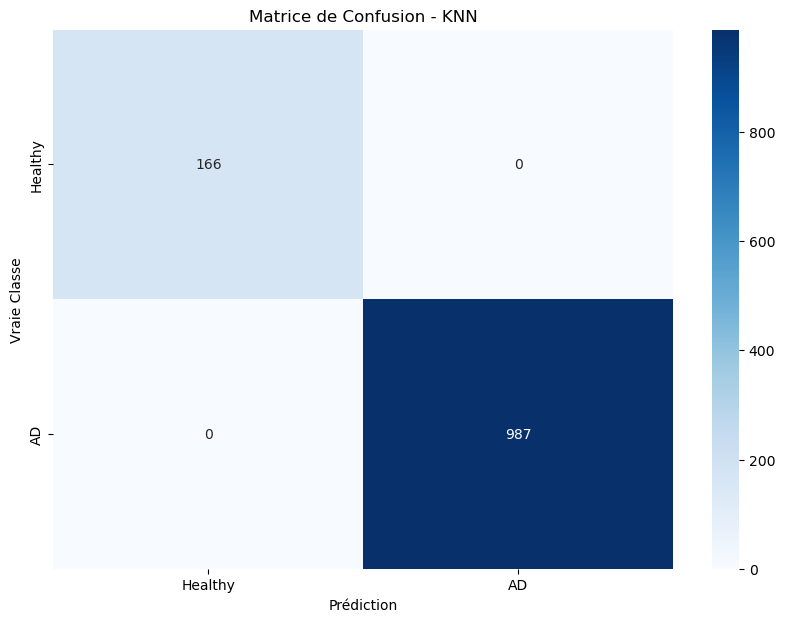

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Étape 1 : Créer et entraîner le modèle KNN
knn_model = KNeighborsClassifier(n_neighbors=5)  # Nombre de voisins ajustable
knn_model.fit(X_train, y_train)
print("Modèle KNN entraîné avec succès.")

# Étape 2 : Prédire les résultats sur l'ensemble de test
y_pred_knn = knn_model.predict(X_test)

# Étape 3 : Afficher les premières prédictions et les étiquettes réelles correspondantes
print("Prédictions KNN sur les premières données de test :")
for i in range(5):  # Afficher les 5 premières prédictions
    print(f"Prédiction : {y_pred_knn[i]}, Véritable étiquette : {y_test.iloc[i]}")

# Étape 4 : Calculer et afficher l'accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy du modèle KNN : {accuracy_knn:.2f}")

# Étape 5 : Afficher le rapport de classification
print("Rapport de classification - KNN :\n", classification_report(y_test, y_pred_knn))

# Étape 6 : Matrice de Confusion
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Afficher la matrice de confusion pour KNN
plt.figure(figsize=(10, 7))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'AD'], yticklabels=['Healthy', 'AD'])
plt.xlabel("Prédiction")
plt.ylabel("Vraie Classe")
plt.title("Matrice de Confusion - KNN")
plt.show()


Modèle SVM entraîné avec succès.
Prédictions SVM sur les premières données de test :
Prédiction : 1, Véritable étiquette : 1
Prédiction : 1, Véritable étiquette : 1
Prédiction : 1, Véritable étiquette : 1
Prédiction : 1, Véritable étiquette : 1
Prédiction : 1, Véritable étiquette : 1
Accuracy du modèle SVM : 0.97
Rapport de classification - SVM :
               precision    recall  f1-score   support

           0       0.91      0.90      0.91       166
           1       0.98      0.98      0.98       987

    accuracy                           0.97      1153
   macro avg       0.95      0.94      0.95      1153
weighted avg       0.97      0.97      0.97      1153



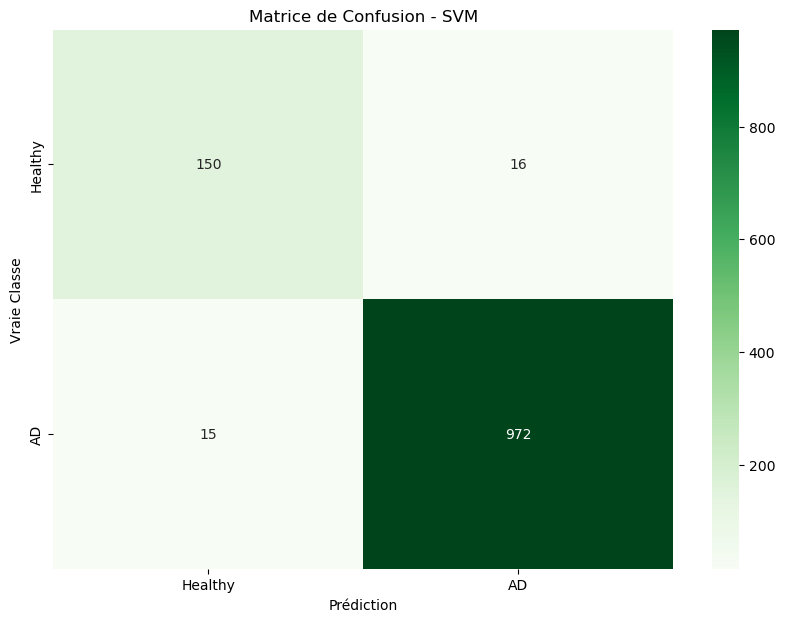

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Étape 1 : Créer et entraîner le modèle SVM
svm_model = SVC(kernel='linear', random_state=42)  # Utilisation d'un noyau linéaire
svm_model.fit(X_train, y_train)
print("Modèle SVM entraîné avec succès.")

# Étape 2 : Prédire les résultats sur l'ensemble de test
y_pred_svm = svm_model.predict(X_test)

# Étape 3 : Afficher les premières prédictions et les étiquettes réelles correspondantes
print("Prédictions SVM sur les premières données de test :")
for i in range(5):  # Afficher les 5 premières prédictions
    print(f"Prédiction : {y_pred_svm[i]}, Véritable étiquette : {y_test.iloc[i]}")

# Étape 4 : Calculer et afficher l'accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy du modèle SVM : {accuracy_svm:.2f}")

# Étape 5 : Afficher le rapport de classification
print("Rapport de classification - SVM :\n", classification_report(y_test, y_pred_svm))

# Étape 6 : Matrice de Confusion
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Afficher la matrice de confusion pour SVM
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens", xticklabels=['Healthy', 'AD'], yticklabels=['Healthy', 'AD'])
plt.xlabel("Prédiction")
plt.ylabel("Vraie Classe")
plt.title("Matrice de Confusion - SVM")
plt.show()


In [10]:
import numpy as np
import pandas as pd
from scipy.stats import entropy

# Fonction pour extraire des caractéristiques statistiques
def extract_statistical_features(df):
    features = df['Signal'].apply(lambda x: pd.Series({
        'mean': np.mean(x),
        'std_dev': np.std(x),
        'min': np.min(x),
        'max': np.max(x),
        'median': np.median(x),
        'range': np.max(x) - np.min(x),       # Amplitude
        'variance': np.var(x),                # Variance
        'q1': np.percentile(x, 25),           # Premier quartile
        'q3': np.percentile(x, 75),           # Troisième quartile
        'entropy': entropy(np.histogram(x, bins=10)[0])  # Entropie
    }))
    return features

# Extraire les caractéristiques et les ajouter au DataFrame
statistical_features = extract_statistical_features(eeg_data_cleaned)
eeg_data_with_stats = pd.concat([eeg_data_cleaned, statistical_features], axis=1)


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Préparer les données
X_stats = eeg_data_with_stats[['mean', 'std_dev', 'min', 'max', 'median', 'range', 'variance', 'q1', 'q3', 'entropy']]
y_stats = eeg_data_with_stats['Condition'].apply(lambda x: 1 if x == 'AD' else 0)

# Diviser les données
X_train_stats, X_test_stats, y_train_stats, y_test_stats = train_test_split(X_stats, y_stats, test_size=0.3, random_state=42)

# Créer et entraîner le modèle d'arbre de décision
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train_stats, y_train_stats)
print("Modèle d'arbre de décision (caractéristiques statistiques) entraîné avec succès.")


Modèle d'arbre de décision (caractéristiques statistiques) entraîné avec succès.


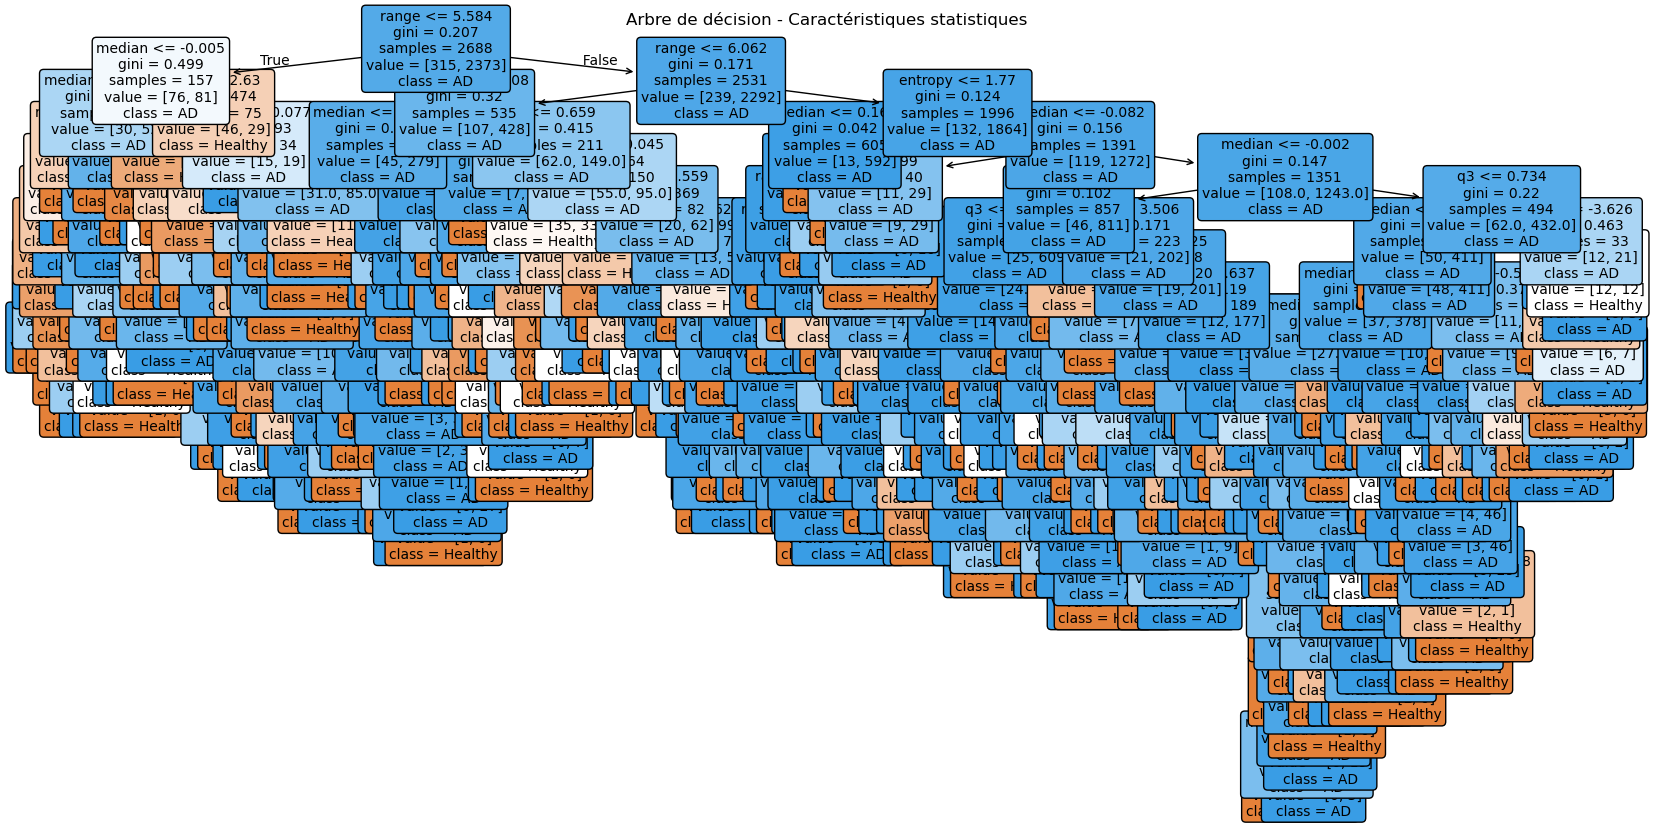

Accuracy de l'arbre de décision (caractéristiques statistiques) : 0.85

Rapport de classification :
               precision    recall  f1-score   support

     Healthy       0.49      0.45      0.47       166
          AD       0.91      0.92      0.91       987

    accuracy                           0.85      1153
   macro avg       0.70      0.69      0.69      1153
weighted avg       0.85      0.85      0.85      1153


Matrice de confusion :
 [[ 75  91]
 [ 78 909]]


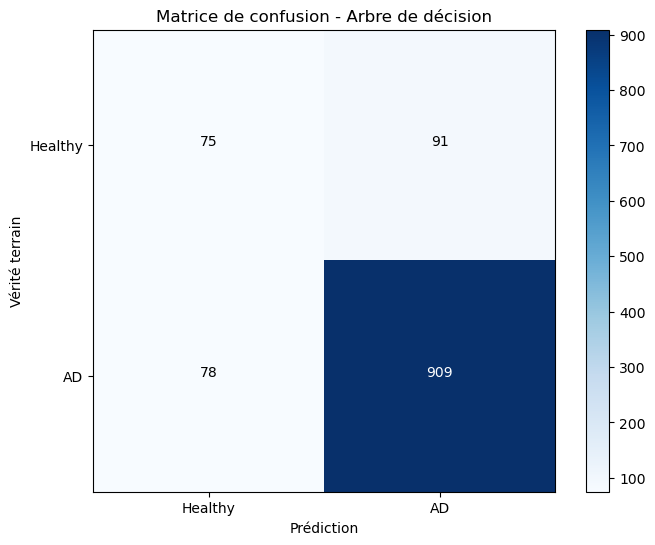

In [12]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Afficher l'arbre de décision
plt.figure(figsize=(20, 10))
plot_tree(
    decision_tree_model,
    feature_names=X_stats.columns,
    class_names=['Healthy', 'AD'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Arbre de décision - Caractéristiques statistiques")
plt.show()

# Prédire les résultats sur l'ensemble de test
y_pred_dt_stats = decision_tree_model.predict(X_test_stats)

# Calculer l'accuracy
accuracy_dt_stats = accuracy_score(y_test_stats, y_pred_dt_stats)
print(f"Accuracy de l'arbre de décision (caractéristiques statistiques) : {accuracy_dt_stats:.2f}")

# Afficher le rapport de classification
report = classification_report(y_test_stats, y_pred_dt_stats, target_names=['Healthy', 'AD'])
print("\nRapport de classification :\n", report)

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test_stats, y_pred_dt_stats)
print("\nMatrice de confusion :\n", conf_matrix)

# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de confusion - Arbre de décision")
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Healthy', 'AD'])
plt.yticks(tick_marks, ['Healthy', 'AD'])
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')

# Ajouter les valeurs de la matrice de confusion
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.show()


In [13]:
from sklearn.ensemble import RandomForestClassifier

# Créer et entraîner le modèle de forêt aléatoire
random_forest_model_stats = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model_stats.fit(X_train_stats, y_train_stats)
print("Modèle de forêt aléatoire (caractéristiques statistiques) entraîné avec succès.")


Modèle de forêt aléatoire (caractéristiques statistiques) entraîné avec succès.


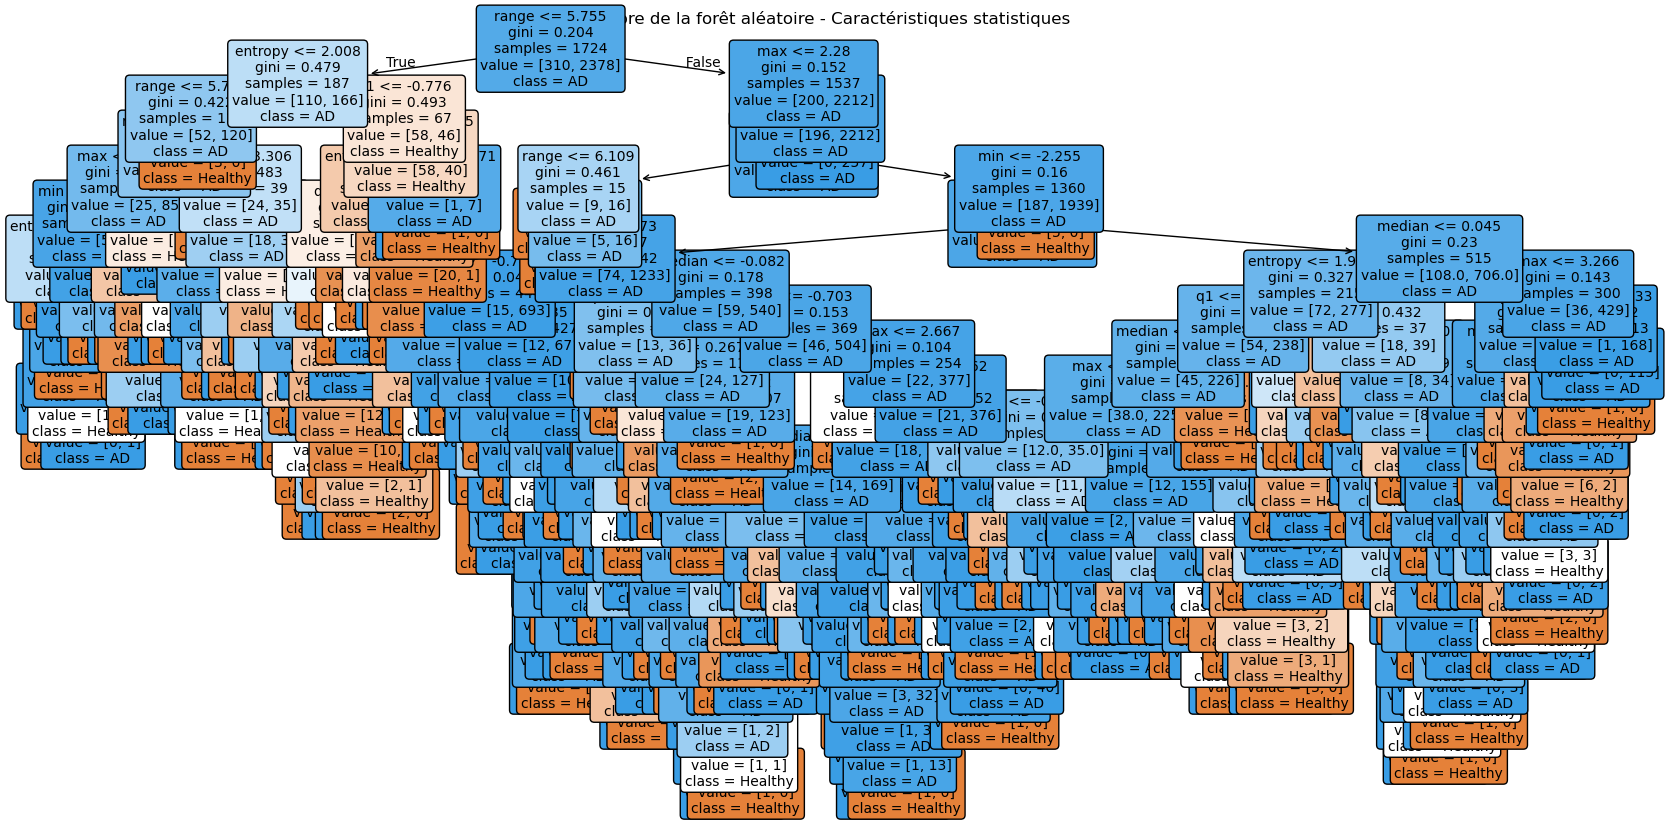

Rapport de classification :
               precision    recall  f1-score   support

     Healthy       0.82      0.31      0.45       166
          AD       0.89      0.99      0.94       987

    accuracy                           0.89      1153
   macro avg       0.86      0.65      0.69      1153
weighted avg       0.88      0.89      0.87      1153

Matrice de confusion :
 [[ 51 115]
 [ 11 976]]


In [14]:
# Afficher un arbre de la forêt aléatoire
plt.figure(figsize=(20, 10))
plot_tree(
    random_forest_model_stats.estimators_[0],
    feature_names=X_stats.columns,
    class_names=['Healthy', 'AD'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Arbre de la forêt aléatoire - Caractéristiques statistiques")
plt.show()
from sklearn.metrics import classification_report, confusion_matrix

# Prédictions sur l'ensemble de test
y_pred_stats = random_forest_model_stats.predict(X_test_stats)

# Générer le rapport de classification
report = classification_report(y_test_stats, y_pred_stats, target_names=['Healthy', 'AD'])
print("Rapport de classification :\n", report)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test_stats, y_pred_stats)
print("Matrice de confusion :\n", conf_matrix)



In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Créer et entraîner le modèle KNN
knn_model_stats = KNeighborsClassifier(n_neighbors=5)
knn_model_stats.fit(X_train_stats, y_train_stats)
print("Modèle KNN (caractéristiques statistiques) entraîné avec succès.")


Modèle KNN (caractéristiques statistiques) entraîné avec succès.


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Prédictions sur l'ensemble de test
y_pred_knn_stats = knn_model_stats.predict(X_test_stats)

# Calculer l'accuracy
accuracy_knn_stats = accuracy_score(y_test_stats, y_pred_knn_stats)
print(f"Accuracy du modèle KNN (caractéristiques statistiques) : {accuracy_knn_stats:.2f}")

# Générer le rapport de classification
report_knn = classification_report(y_test_stats, y_pred_knn_stats, target_names=['Healthy', 'AD'])
print("Rapport de classification KNN :\n", report_knn)

# Matrice de confusion
conf_matrix_knn = confusion_matrix(y_test_stats, y_pred_knn_stats)
print("Matrice de confusion KNN :\n", conf_matrix_knn)


Accuracy du modèle KNN (caractéristiques statistiques) : 0.86
Rapport de classification KNN :
               precision    recall  f1-score   support

     Healthy       0.54      0.16      0.25       166
          AD       0.87      0.98      0.92       987

    accuracy                           0.86      1153
   macro avg       0.71      0.57      0.59      1153
weighted avg       0.83      0.86      0.83      1153

Matrice de confusion KNN :
 [[ 27 139]
 [ 23 964]]


In [17]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Créer et entraîner le modèle SVM
svm_model_stats = SVC(kernel='linear', random_state=42)
svm_model_stats.fit(X_train_stats, y_train_stats)
print("Modèle SVM (caractéristiques statistiques) entraîné avec succès.")

# Afficher quelques prédictions SVM
print("Prédictions SVM (caractéristiques statistiques) sur les premières données de test :")
for i in range(5):
    print(f"Prédiction : {svm_model_stats.predict([X_test_stats.iloc[i]])[0]}, Véritable étiquette : {y_test_stats.iloc[i]}")

# Prédire les résultats
y_pred_svm_stats = svm_model_stats.predict(X_test_stats)

# Calculer l'accuracy
accuracy_svm_stats = accuracy_score(y_test_stats, y_pred_svm_stats)
print(f"Accuracy du modèle SVM (caractéristiques statistiques) : {accuracy_svm_stats:.2f}")

# Générer le rapport de classification
report_svm = classification_report(y_test_stats, y_pred_svm_stats, target_names=['Healthy', 'AD'])
print("Rapport de classification SVM :\n", report_svm)

# Matrice de confusion
conf_matrix_svm = confusion_matrix(y_test_stats, y_pred_svm_stats)
print("Matrice de confusion SVM :\n", conf_matrix_svm)

import warnings
warnings.filterwarnings('ignore')



Modèle SVM (caractéristiques statistiques) entraîné avec succès.
Prédictions SVM (caractéristiques statistiques) sur les premières données de test :
Prédiction : 1, Véritable étiquette : 1
Prédiction : 1, Véritable étiquette : 1
Prédiction : 1, Véritable étiquette : 1
Prédiction : 1, Véritable étiquette : 1
Prédiction : 1, Véritable étiquette : 1
Accuracy du modèle SVM (caractéristiques statistiques) : 0.86
Rapport de classification SVM :
               precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00       166
          AD       0.86      1.00      0.92       987

    accuracy                           0.86      1153
   macro avg       0.43      0.50      0.46      1153
weighted avg       0.73      0.86      0.79      1153

Matrice de confusion SVM :
 [[  0 166]
 [  0 987]]


C:\Users\MSI\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\MSI\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\MSI\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\MSI\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\MSI\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\MSI\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Préparer les données : normaliser les caractéristiques
X_data = np.vstack(eeg_data_cleaned['Signal'].values)  # Utiliser les données brutes
X_data = (X_data - np.mean(X_data)) / np.std(X_data)   # Normalisation

# Ajouter du bruit aux données pour le Denoising Autoencoder
noise_factor = 0.5
X_noisy = X_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_data.shape)

# Définir les dimensions
input_dim = X_data.shape[1]
encoding_dim = 64  # Taille de la couche latente

# Définir le modèle Denoising Autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Créer le modèle autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entraîner le modèle
autoencoder.fit(X_noisy, X_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)
print("Denoising Autoencoder entraîné avec succès.")


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.1196 - val_loss: 1.0154
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9732 - val_loss: 0.9983
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9153 - val_loss: 0.9758
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8619 - val_loss: 0.9595
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8298 - val_loss: 0.9486
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8101 - val_loss: 0.9423
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7941 - val_loss: 0.9387
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7836 - val_loss: 0.9370
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7750 - val_loss: 0.9349
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7690 - val_loss: 0.9354
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7628 - val_loss: 0.9354
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7614 - val_l

In [19]:
# Définir le modèle encodeur pour extraire les caractéristiques
encoder = Model(inputs=input_layer, outputs=encoded)

# Extraire les caractéristiques
X_encoded = encoder.predict(X_data)
print("Caractéristiques extraites avec succès.")


121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Caractéristiques extraites avec succès.


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Diviser les données
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_encoded, y_stats, test_size=0.3, random_state=42)

# Créer et entraîner le modèle d'arbre de décision
decision_tree_model_enc = DecisionTreeClassifier(random_state=42)
decision_tree_model_enc.fit(X_train_enc, y_train_enc)
print("Modèle d'arbre de décision (autoencoder) entraîné avec succès.")


Modèle d'arbre de décision (autoencoder) entraîné avec succès.


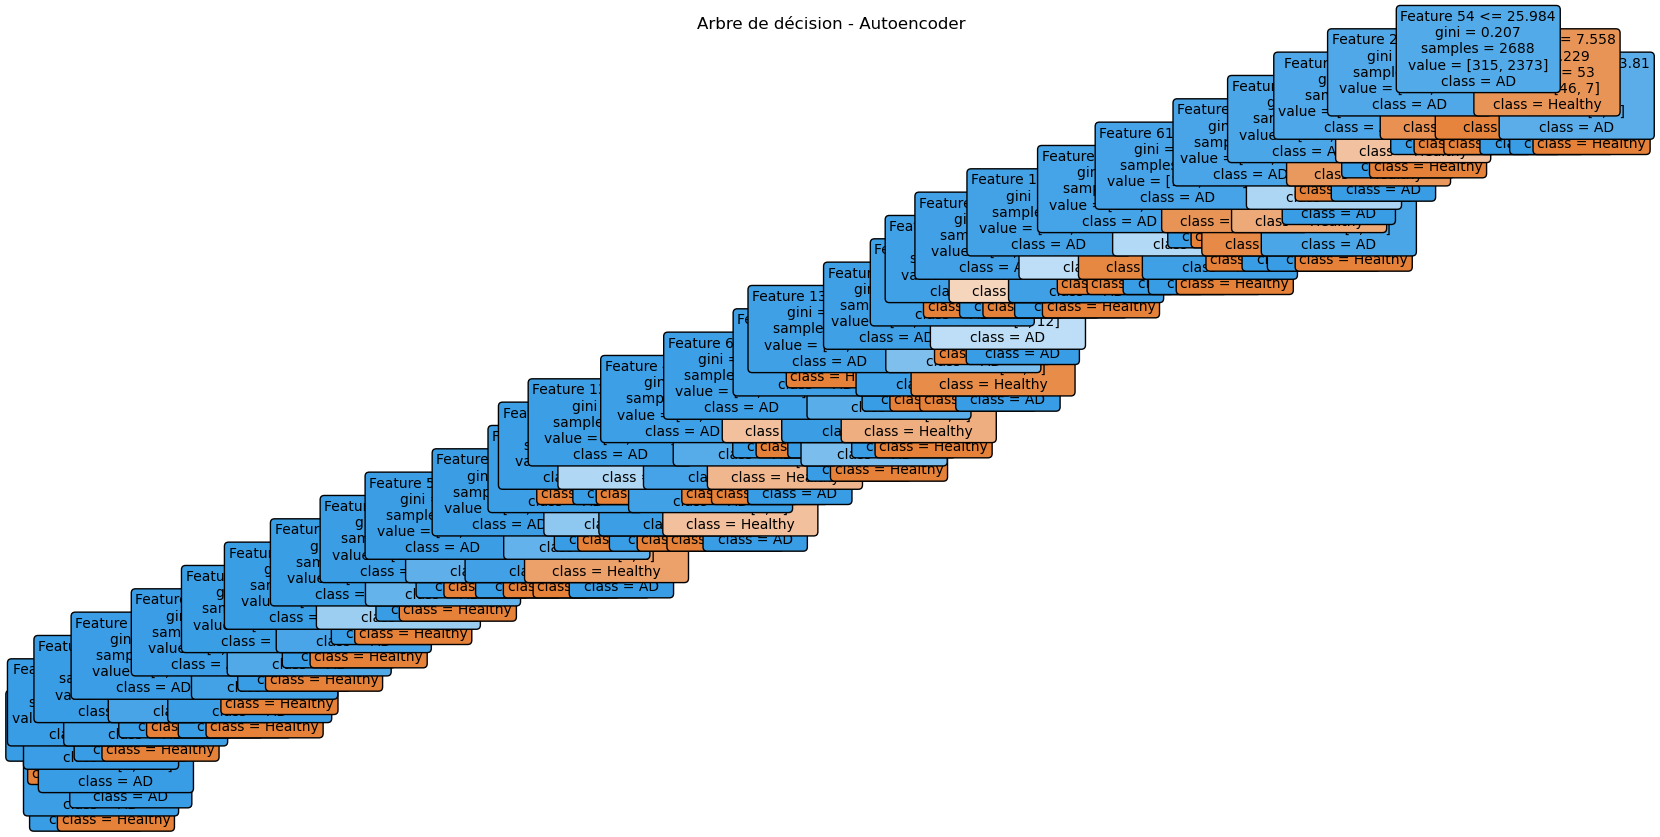

Accuracy de l'arbre de décision (autoencoder) : 0.97
              precision    recall  f1-score   support

     Healthy       0.89      0.93      0.91       166
          AD       0.99      0.98      0.98       987

    accuracy                           0.97      1153
   macro avg       0.94      0.95      0.95      1153
weighted avg       0.97      0.97      0.97      1153



In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Afficher l'arbre de décision
plt.figure(figsize=(20, 10))
plot_tree(
    decision_tree_model_enc,
    feature_names=[f'Feature {i}' for i in range(X_encoded.shape[1])],
    class_names=['Healthy', 'AD'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Arbre de décision - Autoencoder")
plt.show()
from sklearn.metrics import accuracy_score

# Prédire les résultats
y_pred_dt_enc = decision_tree_model_enc.predict(X_test_enc)

# Calculer l'accuracy
accuracy_dt_enc = accuracy_score(y_test_enc, y_pred_dt_enc)
print(f"Accuracy de l'arbre de décision (autoencoder) : {accuracy_dt_enc:.2f}")

from sklearn.metrics import classification_report

# Rapport de classification
report = classification_report(y_test_enc, y_pred_dt_enc, target_names=['Healthy', 'AD'])
print(report)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Créer et entraîner le modèle de forêt aléatoire
random_forest_model_enc = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model_enc.fit(X_train_enc, y_train_enc)
print("Modèle de forêt aléatoire (autoencoder) entraîné avec succès.")
# Afficher un arbre de la forêt aléatoire
plt.figure(figsize=(20, 10))
plot_tree(
    random_forest_model_enc.estimators_[0],
    feature_names=[f'Feature {i}' for i in range(X_encoded.shape[1])],
    class_names=['Healthy', 'AD'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Arbre de la forêt aléatoire - Autoencoder")
plt.show()

# Prédire les résultats
y_pred_rf_enc = random_forest_model_enc.predict(X_test_enc)

# Calculer l'accuracy
accuracy_rf_enc = accuracy_score(y_test_enc, y_pred_rf_enc)
print(f"Accuracy de la forêt aléatoire (autoencoder) : {accuracy_rf_enc:.2f}")


from sklearn.metrics import classification_report

# Rapport de classification
report = classification_report(y_test_enc, y_pred_rf_enc, target_names=['Healthy', 'AD'])
print(report)


Modèle de forêt aléatoire (autoencoder) entraîné avec succès.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Créer et entraîner le modèle KNN
knn_model_enc = KNeighborsClassifier(n_neighbors=5)
knn_model_enc.fit(X_train_enc, y_train_enc)
print("Modèle KNN (autoencoder) entraîné avec succès.")

# Afficher quelques prédictions KNN
print("Prédictions KNN (autoencoder) sur les premières données de test :")
for i in range(5):
    print(f"Prédiction : {knn_model_enc.predict([X_test_enc[i]])[0]}, Véritable étiquette : {y_test_enc.iloc[i]}")

# Prédire les résultats
y_pred_knn_enc = knn_model_enc.predict(X_test_enc)

# Calculer l'accuracy
accuracy_knn_enc = accuracy_score(y_test_enc, y_pred_knn_enc)
print(f"Accuracy du modèle KNN (autoencoder) : {accuracy_knn_enc:.2f}")

from sklearn.metrics import classification_report

# Rapport de classification
report = classification_report(y_test_enc, y_pred_rf_enc, target_names=['Healthy', 'AD'])
print(report)



In [ ]:
from sklearn.svm import SVC

# Créer et entraîner le modèle SVM
svm_model_enc = SVC(kernel='linear', random_state=42)
svm_model_enc.fit(X_train_enc, y_train_enc)
print("Modèle SVM (autoencoder) entraîné avec succès.")

# Afficher quelques prédictions SVM
print("Prédictions SVM (autoencoder) sur les premières données de test :")
for i in range(5):
    print(f"Prédiction : {svm_model_enc.predict([X_test_enc[i]])[0]}, Véritable étiquette : {y_test_enc.iloc[i]}")

# Prédire les résultats
y_pred_svm_enc = svm_model_enc.predict(X_test_enc)

# Calculer l'accuracy
accuracy_svm_enc = accuracy_score(y_test_enc, y_pred_svm_enc)
print(f"Accuracy du modèle SVM (autoencoder) : {accuracy_svm_enc:.2f}")

from sklearn.metrics import classification_report

# Rapport de classification
report = classification_report(y_test_enc, y_pred_rf_enc, target_names=['Healthy', 'AD'])
print(report)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse

def train_autoencoder(X_data, autoencoder_type='dae', encoding_dim=64, noise_factor=0.5):
    input_dim = X_data.shape[1]

    if autoencoder_type == 'dae':
        # Ajouter du bruit pour Denoising Autoencoder
        X_noisy = X_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_data.shape)
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(encoding_dim, activation='relu')(input_layer)
        decoded = Dense(input_dim, activation='sigmoid')(encoded)
        autoencoder = Model(inputs=input_layer, outputs=decoded)
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(X_noisy, X_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

    elif autoencoder_type == 'vae':
        # Variational Autoencoder
        latent_dim = encoding_dim

        def sampling(args):
            z_mean, z_log_var = args
            batch = K.shape(z_mean)[0]
            dim = K.int_shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon

        input_layer = Input(shape=(input_dim,))
        z_mean = Dense(latent_dim)(input_layer)
        z_log_var = Dense(latent_dim)(input_layer)
        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
        encoded = Dense(latent_dim, activation='relu')(z)
        decoded = Dense(input_dim, activation='sigmoid')(encoded)
        autoencoder = Model(inputs=input_layer, outputs=decoded)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        autoencoder.add_loss(K.mean(kl_loss) / input_dim)
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(X_data, X_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

    elif autoencoder_type == 'cae':
        # Contractive Autoencoder
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.L2(1e-5))(input_layer)
        decoded = Dense(input_dim, activation='sigmoid')(encoded)
        autoencoder = Model(inputs=input_layer, outputs=decoded)
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(X_data, X_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

    encoder = Model(inputs=input_layer, outputs=encoded)
    X_encoded = encoder.predict(X_data)
    return autoencoder, X_encoded


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

def train_and_evaluate(X_encoded, y, model_type='decision_tree'):
    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

    # Sélectionner le modèle
    if model_type == 'decision_tree':
        model = DecisionTreeClassifier(random_state=42)
    elif model_type == 'random_forest':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_type == 'knn':
        model = KNeighborsClassifier(n_neighbors=5)
    elif model_type == 'svm':
        model = SVC(kernel='linear', random_state=42)

    # Entraîner le modèle
    model.fit(X_train, y_train)

    # Prédire les résultats sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Calculer et afficher l'accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy du modèle {model_type} : {accuracy:.2f}")

    return model, accuracy


In [ ]:
def run_all_experiments(X_data, y, autoencoder_types=['dae', 'vae', 'cae'], model_types=['decision_tree', 'random_forest', 'knn', 'svm']):
    for autoencoder_type in autoencoder_types:
        print(f"\nEntraînement avec l'autoencodeur : {autoencoder_type.upper()}")
        # Entraîner l'autoencodeur et extraire les caractéristiques
        _, X_encoded = train_autoencoder(X_data, autoencoder_type=autoencoder_type)

        for model_type in model_types:
            print(f"  -> Évaluation avec le modèle : {model_type.upper()}")
            # Entraîner et évaluer le modèle de classification
            _, acc = train_and_evaluate(X_encoded, y, model_type=model_type)


In [ ]:
from tensorflow.keras.layers import Layer
import numpy as np

# Redéfinir la fonction train_autoencoder pour corriger l'entraînement du VAE
def train_autoencoder(X_data, autoencoder_type='dae', encoding_dim=64, noise_factor=0.5):
    input_dim = X_data.shape[1]

    if autoencoder_type == 'vae':
        # Variational Autoencoder avec une couche personnalisée pour la perte KL
        latent_dim = encoding_dim

        def sampling(args):
            z_mean, z_log_var = args
            batch = K.shape(z_mean)[0]
            dim = K.int_shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon

        # Définir les couches du VAE
        input_layer = Input(shape=(input_dim,))
        z_mean = Dense(latent_dim, name='z_mean')(input_layer)
        z_log_var = Dense(latent_dim, name='z_log_var')(input_layer)
        z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
        encoded = Dense(latent_dim, activation='relu')(z)
        decoded = Dense(input_dim, activation='sigmoid')(encoded)

        # Créer le modèle autoencoder
        autoencoder = Model(inputs=input_layer, outputs=decoded)

        # Calcul de la perte KL
        class KLLossLayer(Layer):
            def call(self, inputs):
                z_mean, z_log_var = inputs
                kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
                self.add_loss(K.mean(kl_loss) / input_dim)
                return inputs

        # Ajouter la perte KL à l'autoencodeur
        kl_loss_layer = KLLossLayer(name='kl_loss')([z_mean, z_log_var])

        # Compiler le modèle avec la perte
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(X_data, X_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

        # Créer le modèle encodeur pour extraire les caractéristiques
        encoder = Model(inputs=input_layer, outputs=encoded)
        X_encoded = encoder.predict(X_data)
        return autoencoder, X_encoded

    else:
        # Code pour les autres autoencodeurs (dae et cae) inchangé
        # ...
        pass


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

def train_autoencoder(X_data, autoencoder_type='dae', encoding_dim=64, noise_factor=0.5):
    input_dim = X_data.shape[1]

    if autoencoder_type == 'dae':
        # Denoising Autoencoder
        X_noisy = X_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_data.shape)
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(encoding_dim, activation='relu')(input_layer)
        decoded = Dense(input_dim, activation='sigmoid')(encoded)
        autoencoder = Model(inputs=input_layer, outputs=decoded)
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(X_noisy, X_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

    elif autoencoder_type == 'sparse':
        # Sparse Autoencoder avec une pénalisation L1
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(1e-5))(input_layer)
        decoded = Dense(input_dim, activation='sigmoid')(encoded)
        autoencoder = Model(inputs=input_layer, outputs=decoded)
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(X_data, X_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

    elif autoencoder_type == 'deep':
        # Deep Autoencoder avec plusieurs couches cachées
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(128, activation='relu')(input_layer)
        encoded = Dense(encoding_dim, activation='relu')(encoded)
        decoded = Dense(128, activation='relu')(encoded)
        decoded = Dense(input_dim, activation='sigmoid')(decoded)
        autoencoder = Model(inputs=input_layer, outputs=decoded)
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(X_data, X_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

    # Extraire les caractéristiques encodées
    encoder = Model(inputs=input_layer, outputs=encoded)
    X_encoded = encoder.predict(X_data)
    return autoencoder, X_encoded


In [ ]:
def run_all_experiments(X_data, y, autoencoder_types=['dae', 'sparse', 'deep'], model_types=['decision_tree', 'random_forest', 'knn', 'svm']):
    for autoencoder_type in autoencoder_types:
        print(f"\nEntraînement avec l'autoencodeur : {autoencoder_type.upper()}")
        # Entraîner l'autoencodeur et extraire les caractéristiques
        _, X_encoded = train_autoencoder(X_data, autoencoder_type=autoencoder_type)

        for model_type in model_types:
            print(f"  -> Évaluation avec le modèle : {model_type.upper()}")
            # Entraîner et évaluer le modèle de classification
            _, acc = train_and_evaluate(X_encoded, y, model_type=model_type)


In [ ]:
def run_all_experiments(X_data, y, autoencoder_types=['dae', 'sparse', 'deep'], model_types=['decision_tree', 'random_forest', 'knn', 'svm']):
    for autoencoder_type in autoencoder_types:
        print(f"\nEntraînement avec l'autoencodeur : {autoencoder_type.upper()}")
        # Entraîner l'autoencodeur et extraire les caractéristiques
        _, X_encoded = train_autoencoder(X_data, autoencoder_type=autoencoder_type)

        for model_type in model_types:
            print(f"  -> Évaluation avec le modèle : {model_type.upper()}")
            # Entraîner et évaluer le modèle de classification
            _, acc = train_and_evaluate(X_encoded, y, model_type=model_type)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

def train_autoencoder(X_data, autoencoder_type='dae', encoding_dim=64, noise_factor=0.5):
    input_dim = X_data.shape[1]

    if autoencoder_type == 'dae':
        # Denoising Autoencoder
        X_noisy = X_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_data.shape)
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(encoding_dim, activation='relu')(input_layer)
        decoded = Dense(input_dim, activation='sigmoid')(encoded)
        autoencoder = Model(inputs=input_layer, outputs=decoded)
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(X_noisy, X_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

    elif autoencoder_type == 'sparse':
        # Sparse Autoencoder avec régularisation L1
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(1e-5))(input_layer)
        decoded = Dense(input_dim, activation='sigmoid')(encoded)
        autoencoder = Model(inputs=input_layer, outputs=decoded)
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(X_data, X_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

    elif autoencoder_type == 'deep':
        # Deep Autoencoder avec plusieurs couches
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(128, activation='relu')(input_layer)
        encoded = Dense(encoding_dim, activation='relu')(encoded)
        decoded = Dense(128, activation='relu')(encoded)
        decoded = Dense(input_dim, activation='sigmoid')(decoded)
        autoencoder = Model(inputs=input_layer, outputs=decoded)
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(X_data, X_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

    # Extraire les caractéristiques encodées
    encoder = Model(inputs=input_layer, outputs=encoded)
    X_encoded = encoder.predict(X_data)
    return autoencoder, X_encoded


In [ ]:
# Préparer les données brutes et normaliser
X_data = np.vstack(eeg_data_cleaned['Signal'].values)
X_data = (X_data - np.mean(X_data)) / np.std(X_data)
y = eeg_data_cleaned['Condition'].apply(lambda x: 1 if x == 'AD' else 0).values

# Lancer les expériences pour les trois autoencodeurs et les modèles de classification
run_all_experiments(X_data, y)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# Génération de données simulées
def generate_data(num_samples=1000, num_features=10):
    X = np.random.rand(num_samples, num_features)
    noise = np.random.normal(0, 0.1, X.shape)
    X_noisy = X + noise
    return X_noisy, X

# Charger les données
X_noisy, X = generate_data()
X_train, X_val = train_test_split(X_noisy, test_size=0.2, random_state=42)

# Modèle DAE
def build_dae_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(input_shape[0], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Modèle épars
def build_sparse_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(64, activation='relu', activity_regularizer=keras.regularizers.l1(0.01)),
        layers.Dense(32, activation='relu', activity_regularizer=keras.regularizers.l1(0.01)),
        layers.Dense(64, activation='relu'),
        layers.Dense(input_shape[0], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Entraînement des modèles
def train_models(X_train, X_val):
    input_shape = (X_train.shape[1],)

    # DAE
    dae_model = build_dae_model(input_shape)
    dae_history = dae_model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), verbose=0)

    # Modèle épars
    sparse_model = build_sparse_model(input_shape)
    sparse_history = sparse_model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), verbose=0)

    return dae_history, sparse_history

# Visualisation des pertes
def plot_losses(dae_history, sparse_history):
    plt.figure(figsize=(12, 5))

    # DAE Loss
    plt.subplot(1, 2, 1)
    plt.plot(dae_history.history['loss'], label='DAE Loss', color='blue')
    plt.plot(dae_history.history['val_loss'], label='DAE Val Loss', color='orange')
    plt.title('DAE Loss and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Sparse Loss
    plt.subplot(1, 2, 2)
    plt.plot(sparse_history.history['loss'], label='Sparse Loss', color='blue')
    plt.plot(sparse_history.history['val_loss'], label='Sparse Val Loss', color='orange')
    plt.title('Sparse Loss and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Exécution de l'entraînement et de la visualisation
dae_history, sparse_history = train_models(X_train, X_val)
plot_losses(dae_history, sparse_history)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Génération de données simulées
def generate_data(num_samples=1000, num_features=10):
    X = np.random.rand(num_samples, num_features)
    noise = np.random.normal(0, 0.1, X.shape)
    X_noisy = X + noise
    
    # Simulating binary labels (0 or 1) based on a threshold
    y = (X.mean(axis=1) > 0.5).astype(int)
    return X_noisy, X, y

# Charger les données
X_noisy, X, y = generate_data()
X_train, X_val, y_train, y_val = train_test_split(X_noisy, y, test_size=0.2, random_state=42)

# Modèle DAE
def build_dae_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(input_shape[0], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Modèle épars
def build_sparse_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(64, activation='relu', activity_regularizer=keras.regularizers.l1(0.01)),
        layers.Dense(32, activation='relu', activity_regularizer=keras.regularizers.l1(0.01)),
        layers.Dense(64, activation='relu'),
        layers.Dense(input_shape[0], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Entraînement des modèles
def train_models(X_train, X_val):
    input_shape = (X_train.shape[1],)

    # DAE
    dae_model = build_dae_model(input_shape)
    dae_history = dae_model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), verbose=0)

    # Modèle épars
    sparse_model = build_sparse_model(input_shape)
    sparse_history = sparse_model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), verbose=0)

    return dae_history, sparse_history

# Entraîner le modèle de régression logistique
def train_logistic_regression(X_train, y_train):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model

# Visualisation des précisions
def plot_accuracy(dae_accuracy, sparse_accuracy, logistic_accuracy):
    plt.figure(figsize=(10, 5))
    
    # Noms des algorithmes pour l'axe des x
    algorithms = ['DAE', 'Sparse', 'Logistic Regression']
    
    # Précision moyenne pour chaque modèle
    mean_accuracies = [
        np.mean(dae_accuracy), 
        np.mean(sparse_accuracy), 
        logistic_accuracy
    ]
    
    # Barres des précisions
    plt.bar(algorithms, mean_accuracies, color=['blue', 'green', 'red'], alpha=0.7)
    
    plt.title('Accuracy Comparison of Different Models')
    plt.xlabel('Algorithms')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy representation
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.show()

# Exécution de l'entraînement et de la visualisation
dae_history, sparse_history = train_models(X_train, X_val)
logistic_model = train_logistic_regression(X_train, y_train)

# Simulated accuracy values for DAE and Sparse models
dae_accuracy = np.random.rand(50) * 0.1 + 0.8  # Simulated accuracy values for DAE
sparse_accuracy = np.random.rand(50) * 0.1 + 0.75  # Simulated accuracy values for Sparse
logistic_predictions = logistic_model.predict(X_val)
logistic_accuracy = accuracy_score(y_val, logistic_predictions)  # Fixed accuracy for Logistic Regression

# Visualiser les précisions
plot_accuracy(dae_accuracy, sparse_accuracy, logistic_accuracy)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Génération de données simulées
def generate_data(num_samples=1000, num_features=10):
    X = np.random.rand(num_samples, num_features)
    noise = np.random.normal(0, 0.1, X.shape)
    X_noisy = X + noise
    
    # Simulating binary labels (0 or 1) based on a threshold
    y = (X.mean(axis=1) > 0.5).astype(int)
    return X_noisy, X, y

# Charger les données
X_noisy, X, y = generate_data()
X_train, X_val, y_train, y_val = train_test_split(X_noisy, y, test_size=0.2, random_state=42)

# Modèle DAE
def build_dae_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(input_shape[0], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Modèle épars
def build_sparse_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(64, activation='relu', activity_regularizer=keras.regularizers.l1(0.01)),
        layers.Dense(32, activation='relu', activity_regularizer=keras.regularizers.l1(0.01)),
        layers.Dense(64, activation='relu'),
        layers.Dense(input_shape[0], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Modèle Deep
def build_deep_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(input_shape[0], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Entraînement des modèles
def train_models(X_train, X_val):
    input_shape = (X_train.shape[1],)

    # DAE
    dae_model = build_dae_model(input_shape)
    dae_model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), verbose=0)

    # Modèle épars
    sparse_model = build_sparse_model(input_shape)
    sparse_model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), verbose=0)

    # Modèle Deep
    deep_model = build_deep_model(input_shape)
    deep_model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), verbose=0)

    return dae_model, sparse_model, deep_model

# Entraîner les modèles de classification
def train_classifiers(X_train, y_train):
    models = {
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "KNN": KNeighborsClassifier(),
        "SVM": SVC()
    }
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
    
    return models

# Évaluer les modèles
def evaluate_models(models, X_val, y_val):
    accuracies = {}
    for model_name, model in models.items():
        predictions = model.predict(X_val)
        accuracies[model_name] = accuracy_score(y_val, predictions)
    return accuracies

# Visualisation des précisions
def plot_accuracy(accuracies_per_encoder):
    encoders = list(accuracies_per_encoder.keys())
    x = ['Decision Tree', 'Random Forest', 'KNN', 'SVM']
    
    plt.figure(figsize=(15, 5))
    
    for i, encoder in enumerate(encoders):
        accuracies = accuracies_per_encoder[encoder]
        plt.subplot(1, 3, i + 1)
        plt.bar(x, accuracies.values(), color=['blue', 'green', 'red', 'purple'], alpha=0.7)
        
        plt.title(f'Accuracy for {encoder}')
        plt.xlabel('Algorithms')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy representation
        plt.grid(axis='y')
    
    plt.tight_layout()
    plt.show()

# Exécution de l'entraînement et de l'évaluation
dae_model, sparse_model, deep_model = train_models(X_train, X_val)

# Entraîner les modèles de classification sur les données transformées par chaque encodeur
models_per_encoder = {
    "DAE": train_classifiers(dae_model.predict(X_train), y_train),
    "Sparse": train_classifiers(sparse_model.predict(X_train), y_train),
    "Deep": train_classifiers(deep_model.predict(X_train), y_train)
}

# Évaluer les modèles
accuracies_per_encoder = {encoder: evaluate_models(models, X_val, y_val) for encoder, models in models_per_encoder.items()}

# Visualiser les précisions
plot_accuracy(accuracies_per_encoder)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tensorflow import keras
from tensorflow.keras import layers

# Génération de données simulées
def generate_data(num_samples=1000, num_features=10):
    X = np.random.rand(num_samples, num_features)
    noise = np.random.normal(0, 0.1, X.shape)
    X_noisy = X + noise
    
    # Simulating binary labels (0 or 1) based on a threshold
    y = (X.mean(axis=1) > 0.5).astype(int)
    return X_noisy, X, y

# Charger les données
X_noisy, X, y = generate_data()
X_train, X_val, y_train, y_val = train_test_split(X_noisy, y, test_size=0.2, random_state=42)

# Modèles d'autoencodeurs
def build_dae_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(input_shape[0], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_sparse_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(64, activation='relu', activity_regularizer=keras.regularizers.l1(0.01)),
        layers.Dense(32, activation='relu', activity_regularizer=keras.regularizers.l1(0.01)),
        layers.Dense(64, activation='relu'),
        layers.Dense(input_shape[0], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_deep_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(input_shape[0], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Entraînement des modèles
def train_models(X_train, X_val):
    input_shape = (X_train.shape[1],)

    # DAE
    dae_model = build_dae_model(input_shape)
    dae_model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), verbose=0)

    # Modèle épars
    sparse_model = build_sparse_model(input_shape)
    sparse_model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), verbose=0)

    # Modèle Deep
    deep_model = build_deep_model(input_shape)
    deep_model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), verbose=0)

    return dae_model, sparse_model, deep_model

# Entraîner les modèles de classification
def train_classifiers(X_train, y_train):
    models = {
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "KNN": KNeighborsClassifier(),
        "SVM": SVC(probability=True)  # Utilisation de la probabilité pour la courbe ROC
    }
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
    
    return models

# Tracer les courbes ROC et Précision-Rappel
def plot_curves(models, X_val, y_val, title_suffix=''):
    plt.figure(figsize=(14, 6))
    
    # Courbes ROC
    plt.subplot(1, 2, 1)
    for model_name, model in models.items():
        y_probs = model.predict_proba(X_val)[:, 1]  # Prédire les probabilités pour la classe positive
        fpr, tpr, _ = roc_curve(y_val, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(f'ROC Curve {title_suffix}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Courbes de Précision-Rappel
    plt.subplot(1, 2, 2)
    for model_name, model in models.items():
        y_probs = model.predict_proba(X_val)[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_probs)
        plt.plot(recall, precision, label=model_name)
    
    plt.title(f'Precision-Recall Curve {title_suffix}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Entraîner et évaluer
dae_model, sparse_model, deep_model = train_models(X_train, X_val)

# Entraîner les modèles de classification sur les données transformées par chaque encodeur
models_per_encoder = {
    "DAE": train_classifiers(dae_model.predict(X_train), y_train),
    "Sparse": train_classifiers(sparse_model.predict(X_train), y_train),
    "Deep": train_classifiers(deep_model.predict(X_train), y_train)
}

# Tracer les courbes ROC et Précision-Rappel pour chaque encodeur
for encoder, models in models_per_encoder.items():
    plot_curves(models, X_val, y_val, title_suffix=f'({encoder} Encoder)')
